In [5]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import xarray as xr
import pandas as pd
import scipy.stats as st
import multiprocessing as mp

#Save
import json, h5py
import scipy.io as sio

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

#Predictive Coding Github Repository
sys.path.append('/home/dwyrick/Git/openscope_predictive_coding/')
from openscope_predictive_coding.ophys.dataset.openscope_predictive_coding_dataset import OpenScopePredictiveCodingDataset
from openscope_predictive_coding.ophys.response_analysis.response_analysis import ResponseAnalysis

#User
import openscope_predictive_coding.ophys.decoding_analysis.decoding as dc

#Params
mainseq_ids = [68, 78, 13, 26]
oddball_ids = [6, 17, 22, 51, 71, 89, 103, 110, 111, 112]

SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
PlotDir = os.path.join(SaveDir,'plots')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# data streams for each imaging session are saved as .h5 files in each folder's experiment in this directory
cache_dir = '/srv/data/AllenInst/opc_analysis'

# Read in experiment manifest
manifest_file = '/srv/data/AllenInst/opc_analysis/opc_production_manifest.xlsx'
manifest = pd.read_excel(manifest_file)

# limit to experiments that passed QC
manifest = manifest[manifest['experiment_state']=='passed']
areanames = np.unique(manifest['imaging_area'])

In [3]:
# Concatenate data from all experiments to create pseudopopulation response arrays
# This cell takes a while to run, which is why I've split up the functions of getting the data and selecting the data we want to decode with
randctrl_pseudopop_responses = {}
transctrl_pseudopop_responses = {}
oddball_pseudopop_responses = {}

for area in areanames:
    #For oddball block
    X_oddball, stimulus_df = dc.create_psuedopopulation(manifest, area, block='oddball')
    oddball_pseudopop_responses[area] = X_oddball
    
    #For randomized control pre block
    X_randctrl_pre, stimulus_df = dc.create_psuedopopulation(manifest, area, block='randomized_control_pre')
    
    #For randomized control pre block
    X_randctrl_post, stimulus_df = dc.create_psuedopopulation(manifest, area, block='randomized_control_post')
    randctrl_pseudopop_responses[area] = [X_randctrl_pre, X_randctrl_post]
    
    #For transition control block
    X_transctrl, stimulus_df = dc.create_psuedopopulation(manifest, area, block='transition_control')
    transctrl_pseudopop_responses[area] = X_transctrl
    

/home/dwyrick/miniconda3/envs/ainp/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dwyrick/miniconda3/envs/ainp/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/dwyrick/miniconda3/envs/ainp/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


RSP pseudopopulation created for the oddball block: 1628 neurons from 12 experiments
RSP pseudopopulation created for the randomized_control_pre block: 1628 neurons from 12 experiments
RSP pseudopopulation created for the randomized_control_post block: 1628 neurons from 12 experiments
RSP pseudopopulation created for the transition_control block: 1628 neurons from 12 experiments
VISp pseudopopulation created for the oddball block: 2299 neurons from 15 experiments
VISp pseudopopulation created for the randomized_control_pre block: 2299 neurons from 15 experiments
VISp pseudopopulation created for the randomized_control_post block: 2299 neurons from 15 experiments
VISp pseudopopulation created for the transition_control block: 2299 neurons from 15 experiments
VISpm pseudopopulation created for the oddball block: 2071 neurons from 22 experiments
VISpm pseudopopulation created for the randomized_control_pre block: 2071 neurons from 22 experiments
VISpm pseudopopulation created for the rand

## Decoding Stimulus Condition 
i.e. oddball vs randomized control

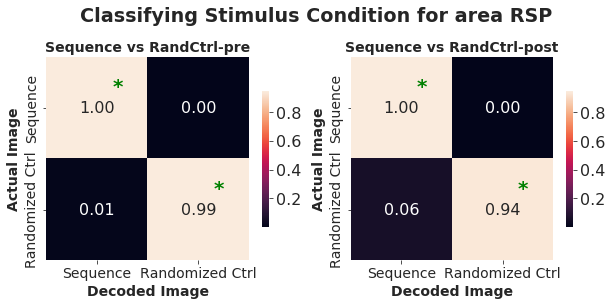

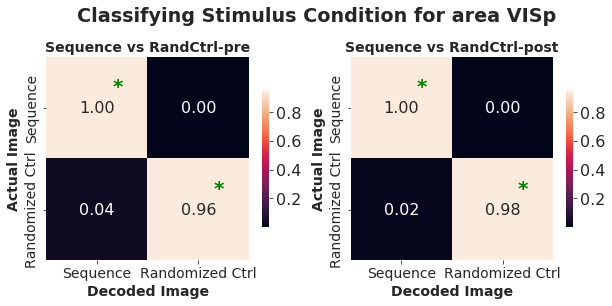

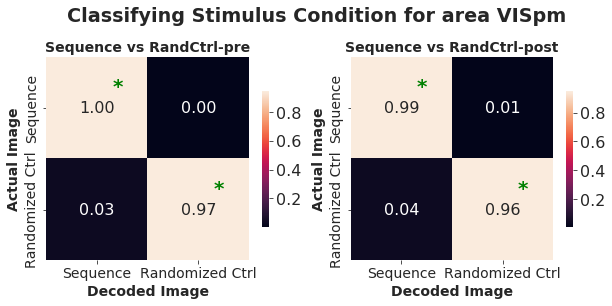

In [65]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
classifier = 'nearest_neighbor'
method='L1O'
PlotDir = os.path.join(SaveDir,'plots')

nClasses = 2
for area in areanames:
    
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    for ii, pstr in enumerate(['pre','post']):
        block_str = 'randomized_control_{}'.format(pstr)
        #Get data for this area
        X_randctrl_all = randctrl_pseudopop_responses[area][ii]
        X_oddball_all = oddball_pseudopop_responses[area]

        #Get trials where MS images were presented from the randomized_ctrl block
        X_randctrl, Y_randctrl, _ = dc.match_trials(X_randctrl_all, stimulus_df, block=block_str, trial_type='ABCD')

        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, _ = dc.match_trials(X_oddball_all, stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(740,860))

        confusion_mat = np.zeros((4,nClasses,nClasses))
        confusion_shf = np.zeros((4,nClasses,nClasses))
        confusion_z = np.zeros((4,nClasses,nClasses))

        nNeurons = X_randctrl.shape[-1]
        for iImg, img_ID in enumerate(mainseq_ids):
            #Get stimulus presentation IDs for this particular image from both blocks
            indy_oddball = np.where(Y_oddball == img_ID)[0]
            indy_randctrl = np.where(Y_randctrl == img_ID)[0]

            #Construct X and Y from both blocks
            X = np.vstack((X_oddball[indy_oddball,:],X_randctrl[indy_randctrl,:]))
            Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))

            #Perform cross-validated decoding analysis
            confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

        fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsOddballBlocks_MSimgs_{}_{}.mat'.format(pstr,area,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)
        
        #Plot shuffle distributions
        title = 'Sequence vs RandCtrl-{}'.format(pstr)
        dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),ax=axes[ii],class_labels=['Sequence','Randomized Ctrl'],title=title)
    plt.suptitle('Classifying Stimulus Condition for area {}'.format(area),y=0.925)
    plt.savefig(os.path.join(PlotDir,'RandomizedCtrlVsOddballBlocks_avg-over-ms_{}_{}.png'.format(area,classifier)))

## Let's see if we can decode the transition control vs oddball context 
using trials where the MS images were presented

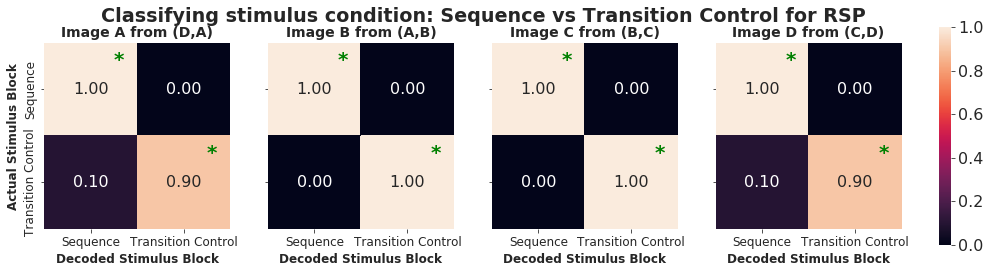

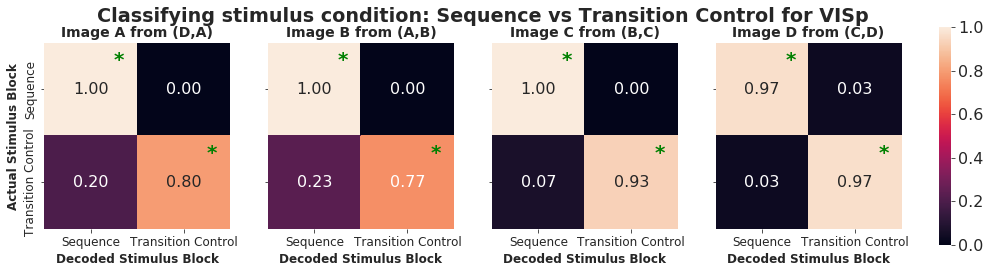

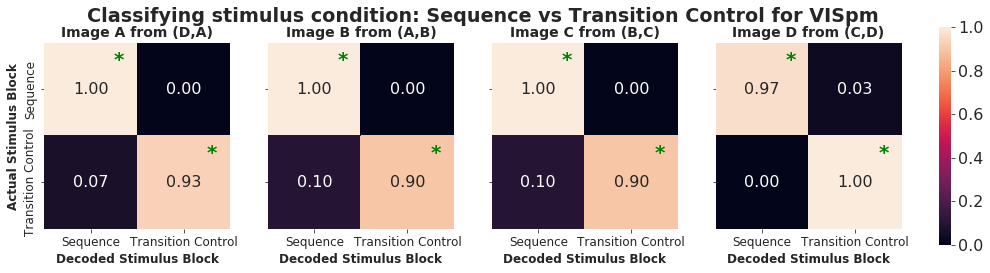

In [118]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
classifier = 'nearest_neighbor'
method='L1O'
PlotDir = os.path.join(SaveDir,'plots')

nClasses = 2
for area in areanames:
    
    #Get trials where MS images were presented from the randomized_ctrl block
    X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area], stimulus_df, block='transition_control', trial_type='ABCD')

    #Get trials where MS images were presented from the middle of the oddball block
    X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(740,860))

    confusion_mat = np.zeros((4,nClasses,nClasses))
    confusion_shf = np.zeros((4,nClasses,nClasses))
    confusion_z = np.zeros((4,nClasses,nClasses))

    nNeurons = X_randctrl.shape[-1]
    for iImg, img_ID in enumerate(mainseq_ids):
        #Get stimulus presentation IDs for this particular image from both blocks
        indy_oddball = np.where(Y_oddball == img_ID)[0]
        indy_transctrl = np.where(Y_transctrl == img_ID)[0]

        #Construct X and Y from both blocks
        X = np.vstack((X_oddball[indy_oddball,:],X_transctrl[indy_transctrl,:]))
        Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))

        #Perform cross-validated decoding analysis
        confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

    fpath = os.path.join(SaveDir,'TransitionCtrlVsOddballBlocks_MSimgs_{}_{}.mat'.format(area,classifier))
    with h5py.File(fpath,'w') as h5file:
        h5file.create_dataset('confusion_mat',data=confusion_mat)
        h5file.create_dataset('confusion_shf',data=confusion_shf)
        h5file.create_dataset('confusion_z',data=confusion_z)
        h5file.create_dataset('area',data=area)
        h5file.create_dataset('classifier',data=classifier)
        h5file.create_dataset('method',data=method)

    title = 'Classifying stimulus condition: Sequence vs Transition Control for {}'.format(area)
    dc.plot_confusion_matrices(confusion_mat, confusion_z, plot_titles=['A from (D,A)','B from (A,B)','C from (B,C)','D from (C,D)'],class_labels=['Sequence','Transition Control'],title=title)
    plt.savefig(os.path.join(PlotDir,'TransitionCtrlVsOddballBlocks_{}_{}.png'.format(area,classifier)))

## What if we compare transition control with randomized control?
Give we can decode the oddball context from both the randomized control and transition control, we might expect the 2 to be indistiguishable...
But that's not what we find!

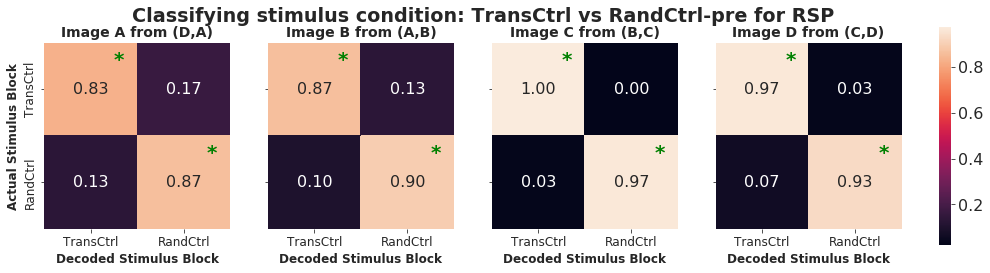

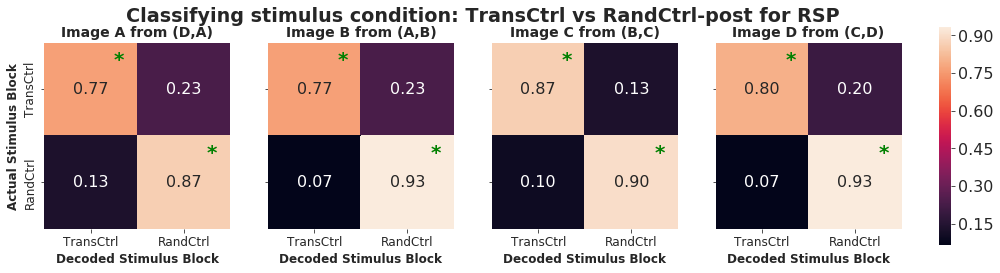

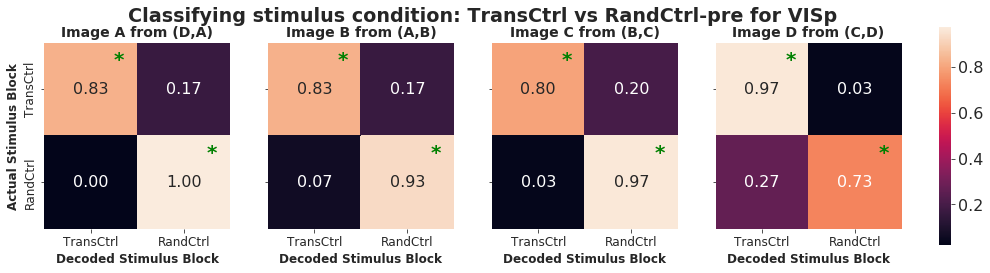

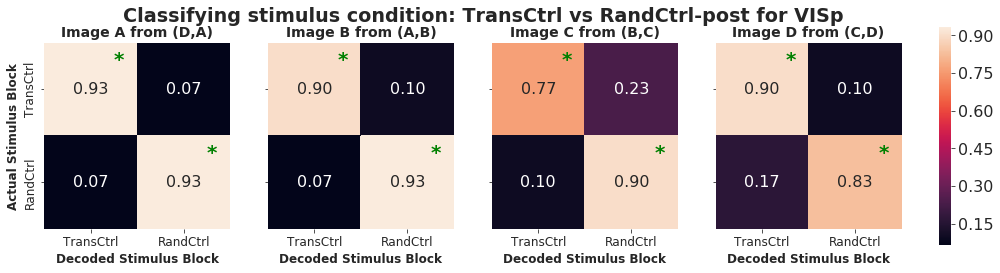

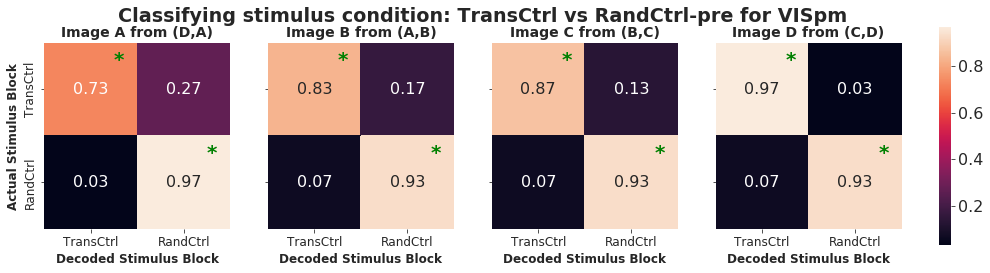

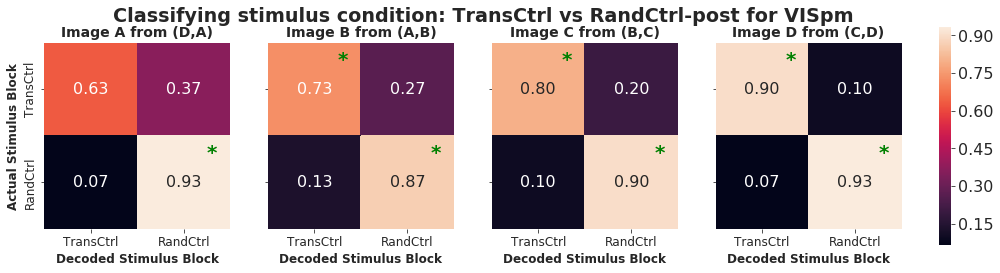

In [128]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
classifier = 'nearest_neighbor'
method='L1O'
PlotDir = os.path.join(SaveDir,'plots')

nClasses = 2
for area in areanames:
    
#     fig, axes = plt.subplots(1,2,figsize=(10,5))
    for ii, pstr in enumerate(['pre','post']):
        block_str = 'randomized_control_{}'.format(pstr)

        #Get trials where MS images were presented from the randomized_ccontrol block
        X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pseudopop_responses[area][ii], stimulus_df, block=block_str, trial_type='ABCD')

        #Get trials where MS images were presented from the transition_control block
        X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area], stimulus_df, block='transition_control', trial_type='ABCD')

        confusion_mat = np.zeros((4,nClasses,nClasses))
        confusion_shf = np.zeros((4,nClasses,nClasses))
        confusion_z = np.zeros((4,nClasses,nClasses))

        nNeurons = X_randctrl.shape[-1]
        for iImg, img_ID in enumerate(mainseq_ids):
            #Get stimulus presentation IDs for this particular image from both blocks
            indy_transctrl = np.where(Y_transctrl == img_ID)[0]
            indy_randctrl = np.where(Y_randctrl == img_ID)[0]

            #Construct X and Y from both blocks
            X = np.vstack((X_transctrl[indy_transctrl,:],X_randctrl[indy_randctrl,:]))
            Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))

            #Perform cross-validated decoding analysis
            confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

        fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsTransitionCtrl_MSimgs_{}_{}.mat'.format(pstr,area,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)
        
#         #Plot shuffle distributions
#         title = 'TransCtrl vs RandCtrl-{}'.format(pstr)
#         dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),ax=axes[ii],class_labels=['Transition Ctrl','Randomized Ctrl'],title=title)
        
        title = 'Classifying stimulus condition: TransCtrl vs RandCtrl-{} for {}'.format(pstr,area)
        dc.plot_confusion_matrices(confusion_mat, confusion_z, plot_titles=['A from (D,A)','B from (A,B)','C from (B,C)','D from (C,D)'],class_labels=['TransCtrl','RandCtrl'],title=title)
        plt.savefig(os.path.join(PlotDir,'TRandomizedCtrlVsTransitionCtrl_{}_{}.png'.format(area,classifier)))
#     plt.suptitle('Classifying Stimulus Condition for area {}'.format(area),y=0.925)
#     plt.savefig(os.path.join(PlotDir,'RandomizedCtrlVsTransitionCtrl_avg-over-ms_{}_{}.png'.format(area,classifier)))

## Let's use the oddball images to see if we decode context
Again, let's start with oddball vs randomized control

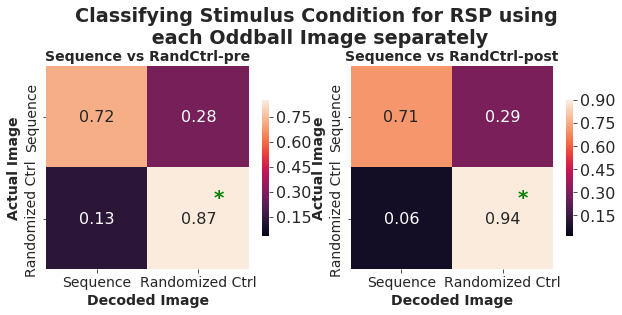

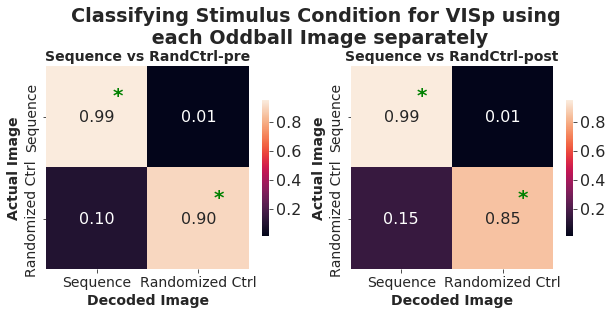

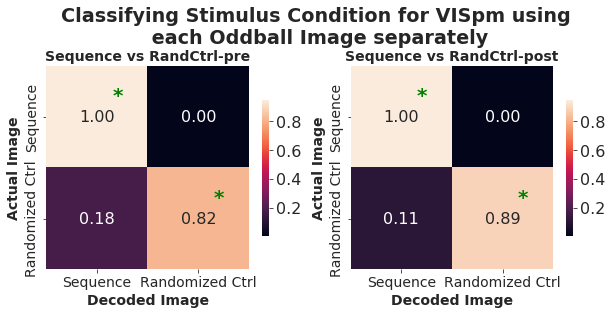

In [158]:
# Let's decode stimulus context per oddball image; i.e. gather trials where an oddball image was presented from both conditions and decode stimulus context that way;
# We will have 10 confusion matrices which we will average over
# The problem with this is that each oddball is only presented 10 times in the oddball block, hence why we are doing leave-1-out x-validation
classifier = 'nearest_neighbor'
method='L1O'
PlotDir = os.path.join(SaveDir,'plots')

for area in areanames:
    
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    for ii, pstr in enumerate(['pre','post']):
        block_str = 'randomized_control_{}'.format(pstr)

        #Get trials where MS images were presented from the randomized_ctrl block
        X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pseudopop_responses[area][ii], stimulus_df, block=block_str, trial_type='X')

        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area], stimulus_df, block='oddball', trial_type='X',trial_indy=slice(740,860))

        confusion_mat = np.zeros((len(oddball_ids),2,2))
        confusion_shf = np.zeros((len(oddball_ids),2,2))
        confusion_z = np.zeros((len(oddball_ids),2,2))

        for iImg, img_ID in enumerate(oddball_ids):
            #Get stimulus presentation IDs for this particular image from both blocks
            indy_oddball = np.where(Y_oddball == img_ID)[0]
            indy_randctrl = np.where(Y_randctrl == img_ID)[0]
            np.random.shuffle(indy_randctrl)

            #Construct X and Y from both blocks
            X = np.vstack((X_oddball[indy_oddball,:],X_randctrl[indy_randctrl[:10],:]))
            Y = np.hstack((np.repeat(0,10),np.repeat(1,10)))

            #Perform cross-validated decoding analysis
            confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

        fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsOddballBlocks_OBimgs_{}_{}.mat'.format(pstr,area,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)
        
        #Plot shuffle distributions
        title = 'Sequence vs RandCtrl-{}'.format(pstr)
        dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),ax=axes[ii],class_labels=['Sequence','Randomized Ctrl'],title=title)
    plt.suptitle('Classifying Stimulus Condition for {} using\n each Oddball Image separately'.format(area),y=0.95)
    plt.savefig(os.path.join(PlotDir,'RandomizedCtrlVsOddballBlocks_avg-over-oddballs_{}_{}.png'.format(area,classifier)))

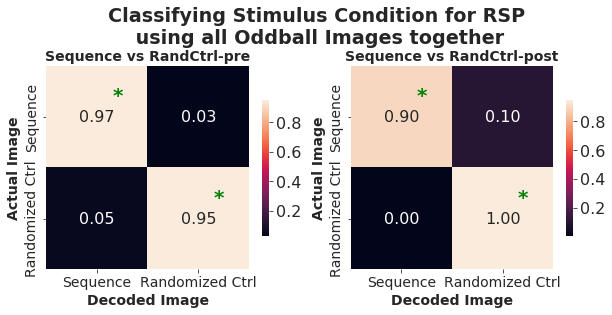

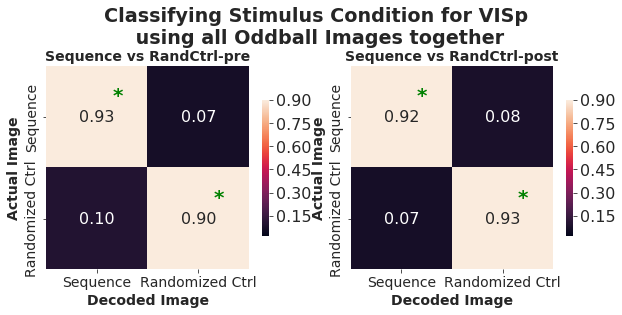

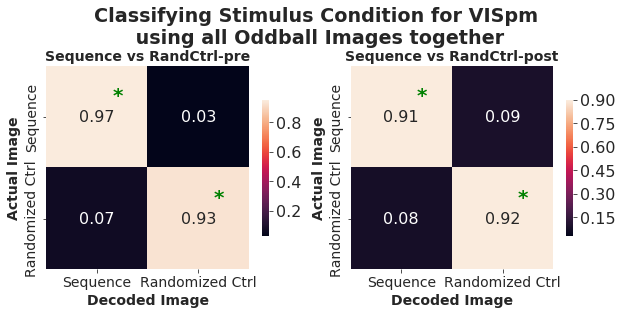

In [159]:
#Let's do the same thing, but combine all the trials where an oddball was presented and use those to decode stimulus context;
#This way we have more trials for each stimulus context
classifier = 'nearest_neighbor'
method='kfold'
PlotDir = os.path.join(SaveDir,'plots')

for area in areanames:
    
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    for ii, pstr in enumerate(['pre','post']):
        block_str = 'randomized_control_{}'.format(pstr)

        #Get trials where MS images were presented from the randomized_ctrl block
        X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pseudopop_responses[area][ii], stimulus_df, block=block_str, trial_type='X')

        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area], stimulus_df, block='oddball', trial_type='X')

        indy_list = []
        for iImg, img_ID in enumerate(oddball_ids):
            tmp = np.where(Y_randctrl == img_ID)[0]
            np.random.shuffle(tmp)
            indy_list.append(tmp[:10])
            
        indy_oddball = np.where(Y_oddball == img_ID)[0]
        indy_randctrl = np.concatenate(indy_list)

        #Construct X and Y from both blocks
        X = np.vstack((X_oddball,X_randctrl[indy_randctrl,:]))
        Y = np.hstack((np.repeat(0,len(Y_oddball)),np.repeat(1,len(indy_randctrl))))
        
        #Create this vector so that the cross validation conserves the proportion of trials for each oddball image in the training and test sets
        Y_sort = np.concatenate((['{}_0'.format(int(yy)) for yy in Y_oddball],['{}_1'.format(int(Y_randctrl[i])) for i in indy_randctrl]))

        #Perform cross-validated decoding analysis
        confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method)

        fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsOddballBlocks_OBimgTogether_{}_{}.mat'.format(pstr,area,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)
        
        #Plot shuffle distributions
        title = 'Sequence vs RandCtrl-{}'.format(pstr)
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['Sequence','Randomized Ctrl'],title=title)
    plt.suptitle('Classifying Stimulus Condition for {}\n using all Oddball Images together'.format(area),y=0.95)
    plt.savefig(os.path.join(PlotDir,'RandomizedCtrlVsOddballBlocks_all-oddballs_{}_{}.png'.format(area,classifier)))

## What about oddball vs transition control?
again using the oddball images separately, then averaging over them

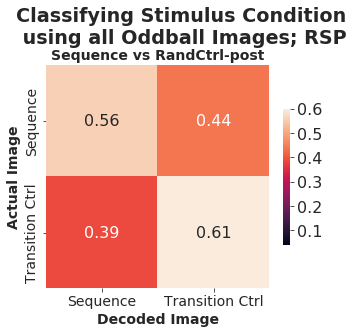

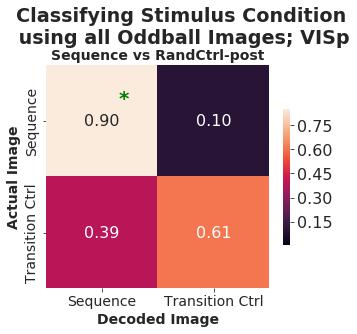

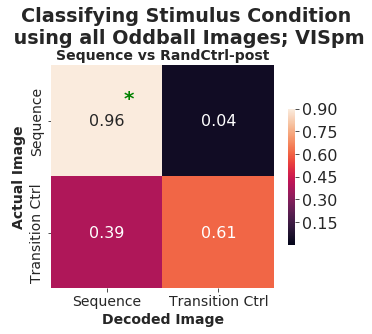

In [170]:
classifier = 'nearest_neighbor'
method='L1O'
PlotDir = os.path.join(SaveDir,'plots')

for area in areanames:
    
    #Get trials where odbball images were presented from the transition_control block
    X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area], stimulus_df, block='transition_control', trial_type='X')

    #Get trials where odbball images were presented from the middle of the oddball block
    X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area], stimulus_df, block='oddball', trial_type='X')

    confusion_mat = np.zeros((len(oddball_ids),2,2))
    confusion_shf = np.zeros((len(oddball_ids),2,2))
    confusion_z = np.zeros((len(oddball_ids),2,2))

    for iImg, img_ID in enumerate(oddball_ids):
        #Get stimulus presentation IDs for this particular image from both blocks
        indy_oddball = np.where(Y_oddball == img_ID)[0]
        indy_transctrl = np.where(Y_transctrl == img_ID)[0]
        np.random.shuffle(indy_transctrl)

        #Construct X and Y from both blocks
        X = np.vstack((X_oddball[indy_oddball,:],X_transctrl[indy_transctrl[:10],:]))
        Y = np.hstack((np.repeat(0,10),np.repeat(1,10)))

        #Perform cross-validated decoding analysis
        confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)
    
    fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsOddballBlocks_OBimgs_{}_{}.mat'.format(pstr,area,classifier))
    with h5py.File(fpath,'w') as h5file:
        h5file.create_dataset('confusion_mat',data=confusion_mat)
        h5file.create_dataset('confusion_shf',data=confusion_shf)
        h5file.create_dataset('confusion_z',data=confusion_z)
        h5file.create_dataset('area',data=area)
        h5file.create_dataset('classifier',data=classifier)
        h5file.create_dataset('method',data=method)

    #Plot shuffle distributions
    dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),class_labels=['Sequence','Transition Ctrl'],title=title)
    plt.suptitle('Classifying Stimulus Condition\n using all Oddball Images; {}'.format(area),y=0.975)
    plt.savefig(os.path.join(PlotDir,'TransitionCtrlVsOddballBlocks_avg-over-oddballs_{}_{}.png'.format(area,classifier)))

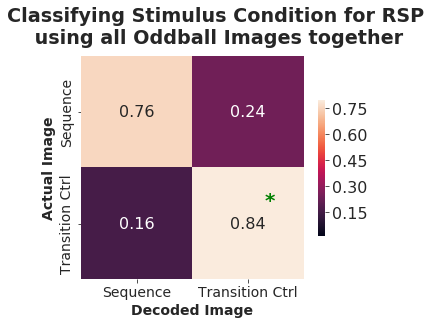

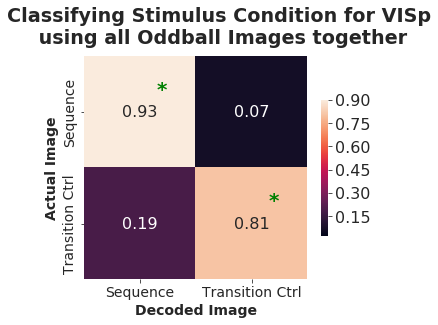

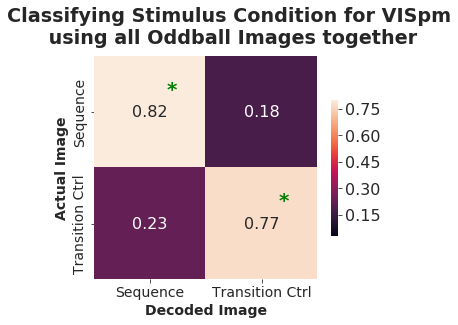

In [175]:
#For completeness sakes, let's do the same thing, but combine all the trials where an oddball was presented and use those to decode stimulus context;
#This way we have more trials for each stimulus context
classifier = 'nearest_neighbor'
method='kfold'
PlotDir = os.path.join(SaveDir,'plots')

for area in areanames:
    
    #Get trials where odbball images were presented from the transition_control block
    X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area], stimulus_df, block='transition_control', trial_type='X')

    #Get trials where MS images were presented from the middle of the oddball block
    X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area], stimulus_df, block='oddball', trial_type='X')

    #Since the transition control block has more than 10 trials per oddball image, we have to take 10 randomly
    indy_list = []
    for img_ID in oddball_ids:
        tmp = np.where(Y_transctrl == img_ID)[0]
        np.random.shuffle(tmp)
        indy_list.append(tmp[:10])

    indy_transctrl = np.concatenate(indy_list)

    #Construct X and Y from both blocks
    X = np.vstack((X_oddball,X_transctrl[indy_transctrl,:]))
    Y = np.hstack((np.repeat(0,len(Y_oddball)),np.repeat(1,len(indy_transctrl))))

    #Create this vector so that the cross validation conserves the proportion of trials for each oddball image in the training and test sets
    Y_sort = np.concatenate((['{}_0'.format(int(yy)) for yy in Y_oddball],['{}_1'.format(int(Y_transctrl[i])) for i in indy_transctrl]))

    #Perform cross-validated decoding analysis
    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method)

    fpath = os.path.join(SaveDir,'TransitionCtrl-{}VsOddballBlocks_OBimgTogether_{}_{}.mat'.format(pstr,area,classifier))
    with h5py.File(fpath,'w') as h5file:
        h5file.create_dataset('confusion_mat',data=confusion_mat)
        h5file.create_dataset('confusion_shf',data=confusion_shf)
        h5file.create_dataset('confusion_z',data=confusion_z)
        h5file.create_dataset('area',data=area)
        h5file.create_dataset('classifier',data=classifier)
        h5file.create_dataset('method',data=method)

    #Plot shuffle distributions
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['Sequence','Transition Ctrl'])
    plt.suptitle('Classifying Stimulus Condition for {}\n using all Oddball Images together'.format(area),y=0.95)
    plt.savefig(os.path.join(PlotDir,'TransitionCtrlVsOddballBlocks_all-oddballs_{}_{}.png'.format(area,classifier)))

## What about transition control vs randomized control?
using the oddball images 

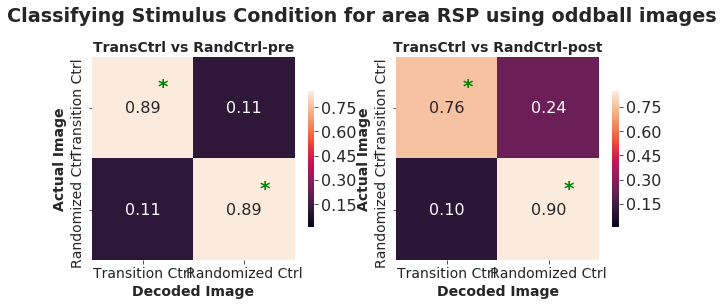

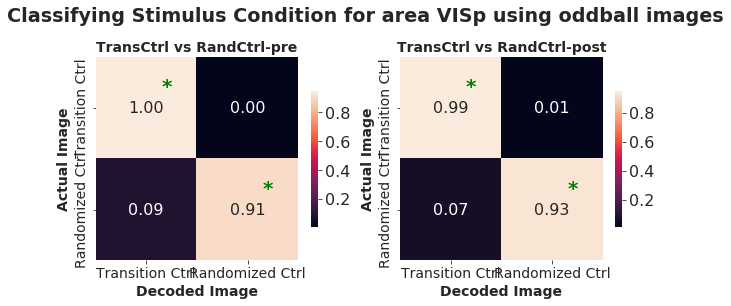

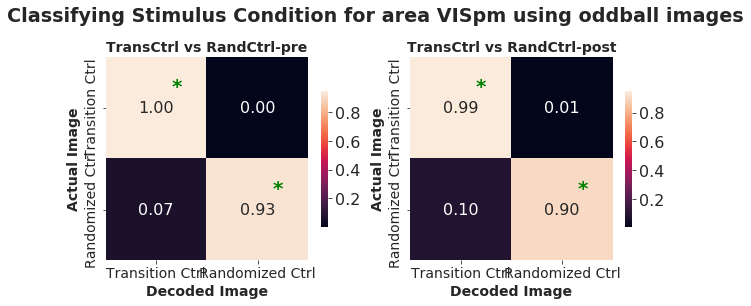

In [142]:
classifier = 'nearest_neighbor'
method='L1O'
PlotDir = os.path.join(SaveDir,'plots')

nClasses = 2
for area in areanames:
    
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    for ii, pstr in enumerate(['pre','post']):
        block_str = 'randomized_control_{}'.format(pstr)

        #Get trials where MS images were presented from the randomized_ccontrol block
        X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pseudopop_responses[area][ii], stimulus_df, block=block_str, trial_type='X')

        #Get trials where MS images were presented from the transition_control block
        X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area], stimulus_df, block='transition_control', trial_type='X')

        confusion_mat = np.zeros((len(oddball_ids),2,2))
        confusion_shf = np.zeros((len(oddball_ids),2,2))
        confusion_z = np.zeros((len(oddball_ids),2,2))

        for iImg, img_ID in enumerate(oddball_ids):
            #Get stimulus presentation IDs for this particular image from both blocks
            indy_transctrl = np.where(Y_transctrl == img_ID)[0]
            indy_randctrl = np.where(Y_randctrl == img_ID)[0]

            #Construct X and Y from both blocks
            X = np.vstack((X_transctrl[indy_transctrl,:],X_randctrl[indy_randctrl,:]))
            Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))

            #Perform cross-validated decoding analysis
            confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

        fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsTransitionCtrl_MSimgs_{}_{}.mat'.format(pstr,area,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)
        
        #Plot shuffle distributions
        title = 'TransCtrl vs RandCtrl-{}'.format(pstr)
        dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),ax=axes[ii],class_labels=['Transition Ctrl','Randomized Ctrl'],title=title)
        
    plt.suptitle('Classifying Stimulus Condition for area {} using oddball images'.format(area),y=0.925)
    plt.savefig(os.path.join(PlotDir,'RandomizedCtrlVsTransitionCtrl_avg-over-oddballs_{}_{}.png'.format(area,classifier)))

## Let's try to decode trials in which image A followed image D vs an oddball
i.e. DA vs XA transitions in the transition control

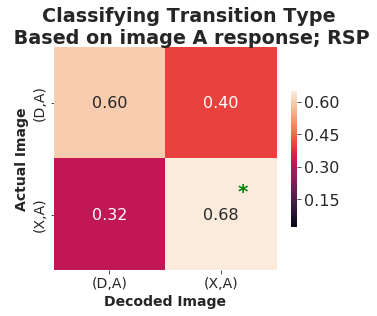

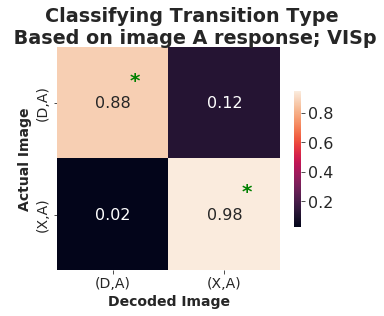

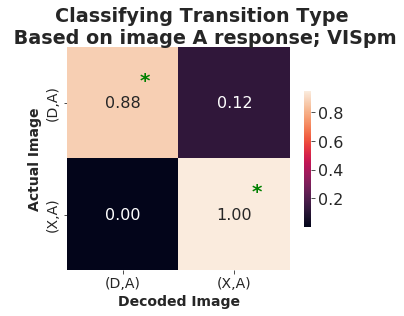

In [186]:
#In the transition control, there are 30 trials per transition type. so, there are 30 trials where DA are presented in series and 30 trials where DX are presented per oddball
#So, given the # of trials per transition type, I created a decoder for each XA type, keeping the DA trials the same
method='L1O'
PlotDir = os.path.join(SaveDir,'plots')

nClasses = 2
for area in areanames:
    #Get trials where A images were presented from the transition_control block
    X_transctrl, Y_transctrl, Y_sort = dc.match_trials(transctrl_pseudopop_responses[area], stimulus_df, block='transition_control', trial_type='DAXA')

    confusion_mat = np.zeros((len(oddball_ids),2,2))
    confusion_shf = np.zeros((len(oddball_ids),2,2))
    confusion_z = np.zeros((len(oddball_ids),2,2))

    for iImg, img_ID in enumerate(oddball_ids):
        #Get stimulus presentation IDs for this particular image from both blocks
        indy_DA = np.where(Y_sort == mainseq_ids[0])[0]
        indy_XA = np.where(Y_sort == img_ID)[0]

        #Construct X and Y from both blocks
        X = np.vstack((X_transctrl[indy_DA,:],X_transctrl[indy_XA,:]))
        Y = np.hstack((np.repeat(0,len(indy_DA)),np.repeat(1,len(indy_XA))))

        #Perform cross-validated decoding analysis
        confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)
    
    fpath = os.path.join(SaveDir,'DAvsXA_TransCtrl-block_{}_{}.mat'.format(area,classifier))
    with h5py.File(fpath,'w') as h5file:
        h5file.create_dataset('confusion_mat',data=confusion_mat)
        h5file.create_dataset('confusion_shf',data=confusion_shf)
        h5file.create_dataset('confusion_z',data=confusion_z)
        h5file.create_dataset('area',data=area)
        h5file.create_dataset('classifier',data=classifier)
        h5file.create_dataset('method',data=method)

    #Plot shuffle distributions
    dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),class_labels=['(D,A)','(X,A)'])
        
    plt.suptitle('Classifying Transition Type\n Based on image A response; {}'.format(area),y=0.925)
    plt.savefig(os.path.join(PlotDir,'DAvsXA_TransCtrl-block_{}_{}.png'.format(area,classifier)))

## Image Identity
Let's see if we can decode image identity in the randomized blocks using the pseudopopulation 

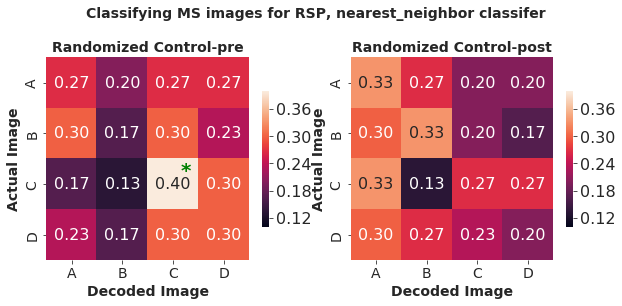

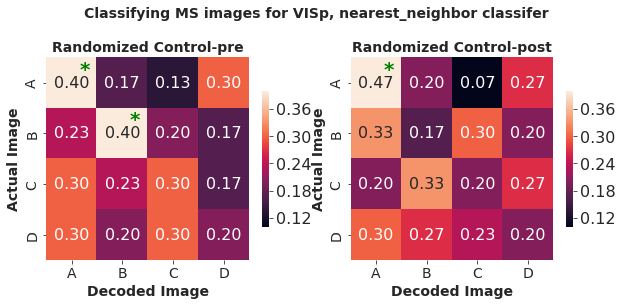

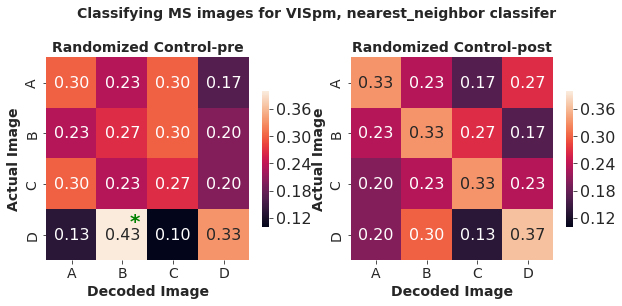

In [6]:
classifier = 'nearest_neighbor'
method='L1O'
for area in areanames:
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    for ii, pstr in enumerate(['pre','post']):
        block_str = 'randomized_control_{}'.format(pstr)
        X_randctrl_all = randctrl_pseudopop_responses[area][ii]

        #Get trials where MS images were presented from the randomized_ctrl block
        X_randctrl, Y_randctrl, _ = dc.match_trials(X_randctrl_all, stimulus_df, block=block_str, trial_type='ABCD')

        #Use pseudopopulation vectors for decoding
        confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_randctrl,Y_randctrl,method=method,classifier=classifier,clabels=mainseq_ids)

        fpath = os.path.join(SaveDir,'mainseq_decoding_{}-block_{}_{}.mat'.format(block_str,area,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)
        
        title_str = 'Randomized Control-{}'.format(pstr)
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D'],title=title_str,clims=[0.1,0.4])

    plt.suptitle('Classifying MS images for {}, {} classifer'.format(area,classifier),y=0.925,fontsize=14)
    plt.savefig(os.path.join(PlotDir,'mainseq_decoding_randctrl-blocks_{}_{}.png'.format(area,classifier)))

## What if we combine randomized control pre and post?

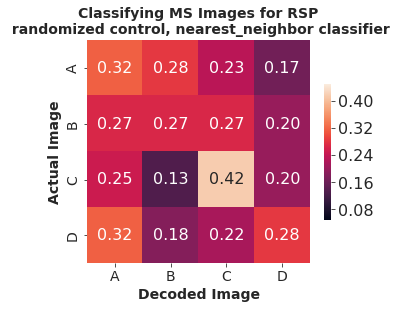

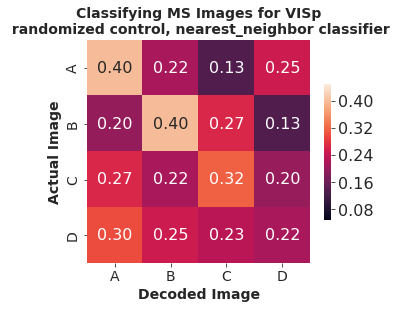

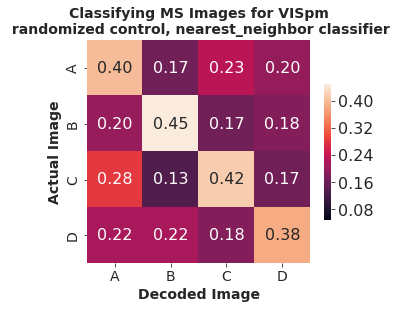

In [89]:
classifier = 'nearest_neighbor'

for ii,area in enumerate(areanames):
 
    #Get trials where MS images were presented from the randomized_ctrl block
    X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(randctrl_pseudopop_responses[area][0], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
    X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(randctrl_pseudopop_responses[area][1], stimulus_df, block='randomized_control_post', trial_type='ABCD')

    X_combined = np.vstack((X_randctrl_pre,X_randctrl_post))
    Y_combined = np.hstack((Y_randctrl_pre,Y_randctrl_post))
    
    #Use pseudopopulation vectors for decoding
    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_combined,Y_combined,method='kfold',nKfold=5,classifier=classifier,plot_shuffle=True,clabels=mainseq_ids)

    fpath = os.path.join(SaveDir,'X-img_decoding_randomized-ctrl-block_{}_{}.mat'.format(area,classifier))
    with h5py.File(fpath,'w') as h5file:
        h5file.create_dataset('confusion_mat',data=confusion_mat)
        h5file.create_dataset('confusion_shf',data=confusion_shf)
        h5file.create_dataset('confusion_z',data=confusion_z)
        h5file.create_dataset('area',data=area)
        h5file.create_dataset('classifier',data=classifier)
        h5file.create_dataset('method',data=method)

    dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D'],title=title_str,annot=True,clims=[0.05,0.45])
plt.suptitle('Classifying MS Images in randomized control block, {} classifier'.format(classifier))
plt.savefig(os.path.join(PlotDir,'mainseq_decoding_randctrl-combined_{}.png'.format(classifier)))

## Let's see if we can decode image identity in the transition control block
using the second images of the (D,A),(A,B),(B,C),(C,D) transitions 

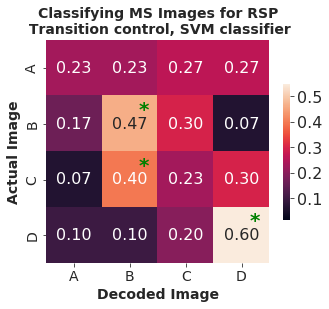

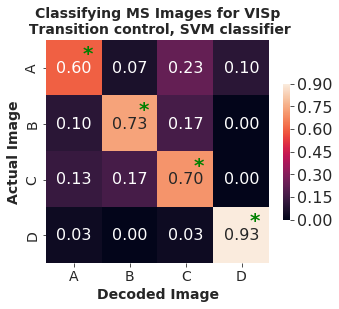

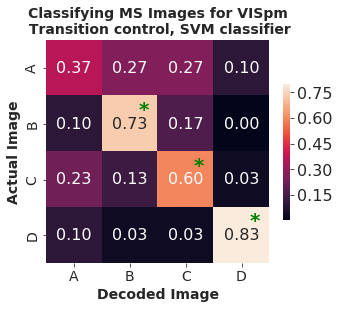

In [8]:
classifier = 'SVM'

fig, axes = plt.subplots(1,3,figsize=(15,5))
for area in areanames:
 
    #Get trials where MS images were presented from the transition control block
    X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area], stimulus_df, block='transition_control', trial_type='ABCD')

    #Use pseudopopulation vectors for decoding
    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_transctrl,Y_transctrl,classifier=classifier,plot_shuffle=False,clabels=mainseq_ids)

    fpath = os.path.join(SaveDir,'mainseq_decoding_transition-ctrl-block_{}_{}.mat'.format(area,classifier))
    with h5py.File(fpath,'w') as h5file:
        h5file.create_dataset('confusion_mat',data=confusion_mat)
        h5file.create_dataset('confusion_shf',data=confusion_shf)
        h5file.create_dataset('confusion_z',data=confusion_z)
        h5file.create_dataset('area',data=area)
        h5file.create_dataset('classifier',data=classifier)
        h5file.create_dataset('method',data=method)

    title_str = 
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D'],title=area,annot=True)
plt.suptitle('Classifying MS Images in transition control block, {} classifier'.format(classifier))
plt.savefig(os.path.join(PlotDir,'mainseq_decoding_transition-ctrl-block_{}.png'.format(classifier)))

## Can we decode image identity in the oddball block?
Let's use the first 240 trials, then 240 trials in the middle, then the last 240 trials

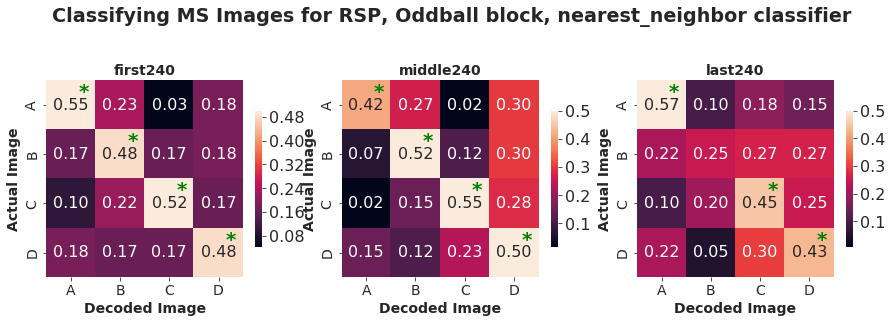

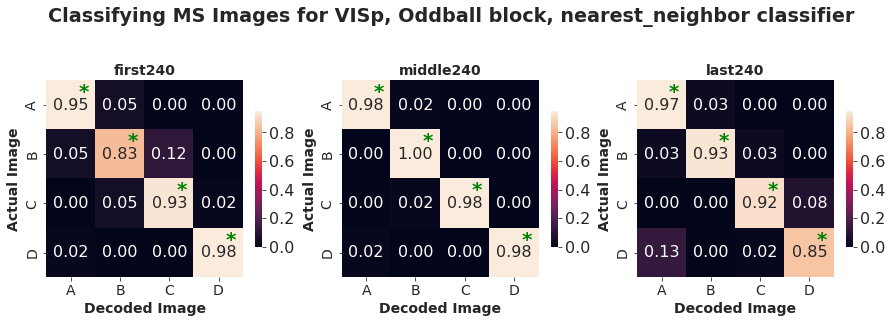

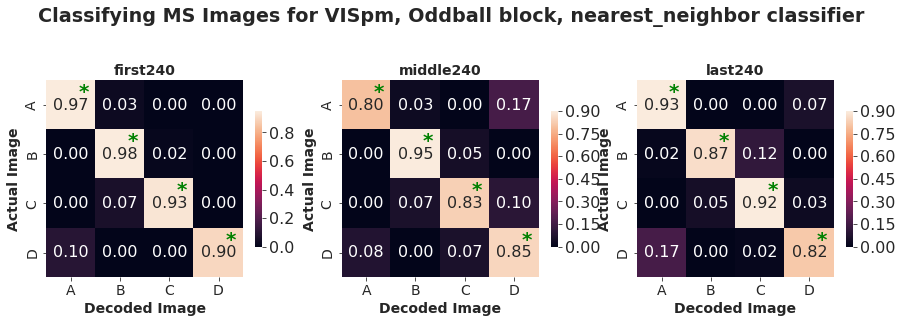

In [26]:
classifier = 'nearest_neighbor'

slice_list = [slice(0,240),slice(3080,3320),slice(6160,6400)]
slice_str = ['first240','middle240','last240']

for area in areanames:
    
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ii,(sl_val,sl_str) in enumerate(zip(slice_list,slice_str)):
        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=sl_val)

        #Use pseudopopulation vectors for decoding
        confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,classifier=classifier,plot_shuffle=False,clabels=mainseq_ids)

        fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_{}_{}.mat'.format(sl_str,area,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D'],title=sl_str,annot=True)
    plt.suptitle('Classifying MS Images for {}, Oddball block, {} classifier'.format(area,classifier))
    plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball-block_{}_{}.png'.format(area,classifier)))

## What if we use all of the trials possible?

In [ ]:
#This cell takes a long long time because we're using all of the trials
classifier = 'nearest_neighbor'
method='kfold'
fig, axes = plt.subplots(1,3,figsize=(15,5))
for ii,area in enumerate(areanames):
    
    #Get trials where MS images were presented from the middle of the oddball block
    X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area], stimulus_df, block='oddball', trial_type='ABCD')

    #Use pseudopopulation vectors for decoding
    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,method=method,classifier=classifier,plot_shuffle=False,clabels=mainseq_ids)

    fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_alltrials_{}_{}.mat'.format(area,classifier))
    with h5py.File(fpath,'w') as h5file:
        h5file.create_dataset('confusion_mat',data=confusion_mat)
        h5file.create_dataset('confusion_shf',data=confusion_shf)
        h5file.create_dataset('confusion_z',data=confusion_z)
        h5file.create_dataset('area',data=area)
        h5file.create_dataset('classifier',data=classifier)
        h5file.create_dataset('method',data=method)

    dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D'],title=area,annot=True)
plt.suptitle('Classifying MS Images for {}, Oddball block, All trials, {} classifier'.format(area,classifier))
plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball-block_alltrials_{}.png'.format(classifier)))

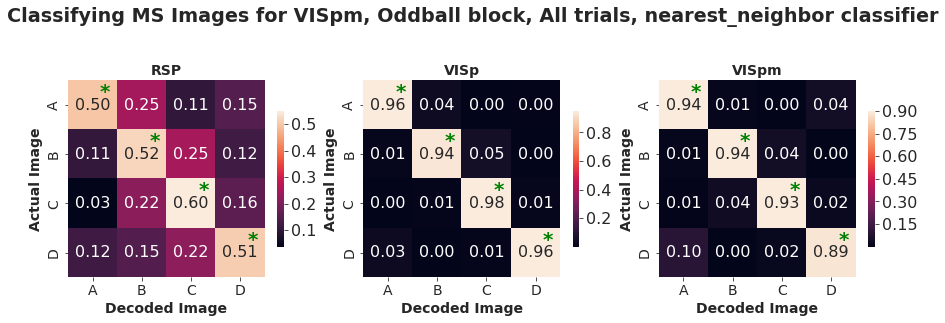

In [32]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
for ii,area in enumerate(areanames):
    fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_alltrials_{}_{}.mat'.format(area,classifier))
    with h5py.File(fpath,'r') as h5file:
        confusion_mat = np.array(h5file['confusion_mat'])
        confusion_z = np.array(h5file['confusion_z'])

    dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D'],title=area,annot=True)
plt.suptitle('Classifying MS Images for {}, Oddball block, All trials, {} classifier'.format(area,classifier))
plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball-block_alltrials_{}.png'.format(classifier)))

## In the oddball block, train on first 240 trials and test on last 240 trials and vice versa

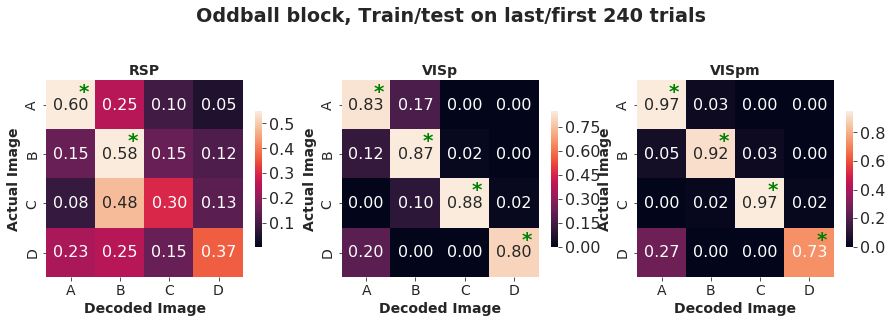

In [17]:
classifier = 'nearest_neighbor'

slice_list = [slice(0,240),slice(3080,3320),slice(6160,6400)]
slice_str = ['first240','middle240','last240']

fig, axes = plt.subplots(1,3,figsize=(15,5))
for ii, area in enumerate(areanames):
    
    #Get trials where MS images were presented from different parts of the oddball block
    X_first240, Y_first240, _ = dc.match_trials(oddball_pseudopop_responses[area], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(0,240))
    X_last240, Y_last240, _ = dc.match_trials(oddball_pseudopop_responses[area], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(6160,6400))
    
    nNeurons = X_first240.shape[-1]
    train_index = np.arange((X_first240.shape[0]))
    
    #Perform cross-validated decoding analysis
    kfold_hits, kfold_shf = dc.decode_labels(X_last240,Y_last240,train_index,None,classifier,mainseq_ids,X_first240,Y_first240)
    
    #Normalize confusion matrix
    confusion_mat = kfold_hits/np.sum(kfold_hits,axis=1).reshape(-1,1)

    nClasses = 4; nShuffles = 100
    #Loop through shuffles and normalize
    c_shf = np.zeros((nShuffles,nClasses,nClasses))
    for iS in range(nShuffles):
        c_shf[iS] = kfold_shf[iS]/np.sum(kfold_shf[iS],axis=1).reshape(-1,1)

    #Calculate z-score for this kfold
    m_shf, s_shf = np.mean(c_shf,axis=0), np.std(c_shf,axis=0)
    confusion_shf = m_shf
    confusion_z = (confusion_mat - m_shf)/s_shf

    fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_trainonlast240_{}_{}.mat'.format(area,classifier))
    with h5py.File(fpath,'w') as h5file:
        h5file.create_dataset('confusion_mat',data=confusion_mat)
        h5file.create_dataset('confusion_shf',data=confusion_shf)
        h5file.create_dataset('confusion_z',data=confusion_z)
        h5file.create_dataset('area',data=area)
        h5file.create_dataset('classifier',data=classifier)
        h5file.create_dataset('method',data=method)

    dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D'],title=area,annot=True)
plt.suptitle('Oddball block, Train/test on last/first 240 trials'.format(classifier))
plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball-block_trainonlast240_{}.png'.format(classifier)))

## Can we decode the oddball images though?


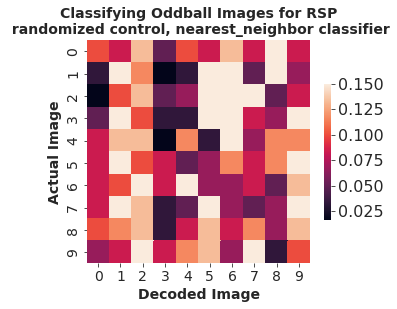

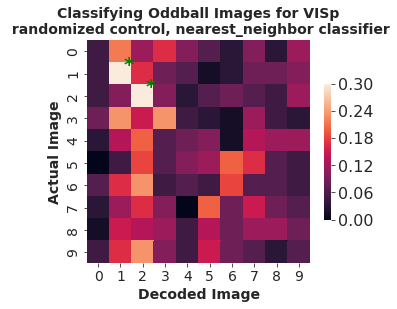

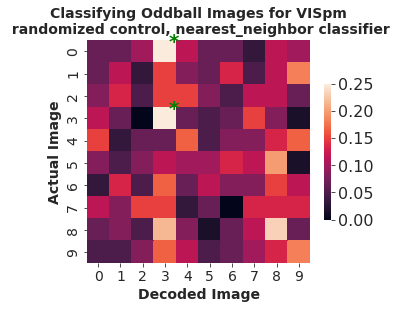

In [85]:
classifier = 'nearest_neighbor'

for area in areanames:
 
    X_randctrl_pre = randctrl_pseudopop_responses[area][0]

    #Get trials where MS images were presented from the randomized_ctrl block
    X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(randctrl_pseudopop_responses[area][0], stimulus_df, block='randomized_control_pre', trial_type='X')
    X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(randctrl_pseudopop_responses[area][1], stimulus_df, block='randomized_control_post', trial_type='X')

    X_combined = np.vstack((X_randctrl_pre,X_randctrl_post))
    Y_combined = np.hstack((Y_randctrl_pre,Y_randctrl_post))
    
    #Use pseudopopulation vectors for decoding
    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_combined,Y_combined,method='kfold',nKfold=5,classifier=classifier,clabels=oddball_ids)

    fpath = os.path.join(SaveDir,'X-img_decoding_randomized-ctrl-block_{}_{}.mat'.format(area,classifier))
    with h5py.File(fpath,'w') as h5file:
        h5file.create_dataset('confusion_mat',data=confusion_mat)
        h5file.create_dataset('confusion_shf',data=confusion_shf)
        h5file.create_dataset('confusion_z',data=confusion_z)
        h5file.create_dataset('area',data=area)
        h5file.create_dataset('classifier',data=classifier)
        h5file.create_dataset('method',data=method)

    title_str = 'Classifying Oddball Images for {}\n randomized control, {} classifier'.format(area,classifier)
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=np.arange(10),title=title_str,annot=False)
    plt.savefig(os.path.join(PlotDir,'X-img_decoding_randctrl-blocks_{}_{}.png'.format(area,classifier)))

## Oddball images from the transition control block

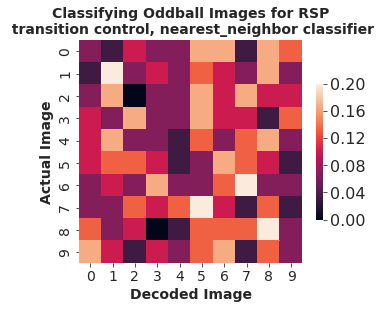

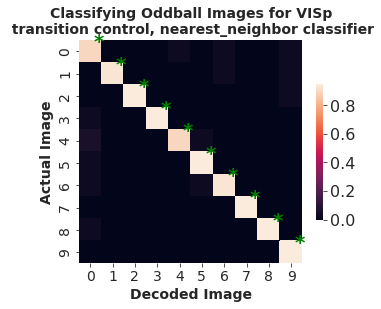

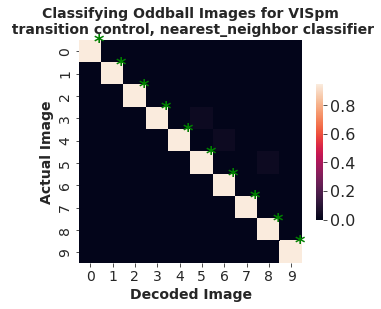

In [13]:
classifier = 'nearest_neighbor'

for area in areanames:
 
    #Get trials where odbball images were presented from the transition_control block
    X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area], stimulus_df, block='transition_control', trial_type='X')
    
    #Use pseudopopulation vectors for decoding
    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_transctrl,Y_transctrl,method='kfold',nKfold=5,classifier=classifier,clabels=oddball_ids)

    fpath = os.path.join(SaveDir,'X-img_decoding_transition-ctrl-block_{}_{}.mat'.format(area,classifier))
    with h5py.File(fpath,'w') as h5file:
        h5file.create_dataset('confusion_mat',data=confusion_mat)
        h5file.create_dataset('confusion_shf',data=confusion_shf)
        h5file.create_dataset('confusion_z',data=confusion_z)
        h5file.create_dataset('area',data=area)
        h5file.create_dataset('classifier',data=classifier)
        h5file.create_dataset('method',data=method)

    title_str = 'Classifying Oddball Images for {}\n transition control, {} classifier'.format(area,classifier)
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=np.arange(10),title=title_str,annot=False)
    plt.savefig(os.path.join(PlotDir,'X-img_decoding_transctrl-blocks_{}_{}.png'.format(area,classifier)))

## Oddball images from the oddball block

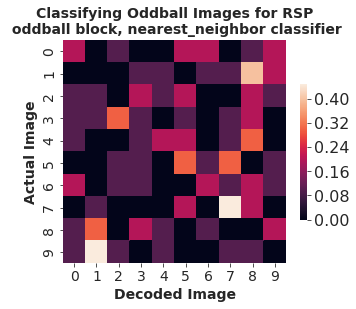

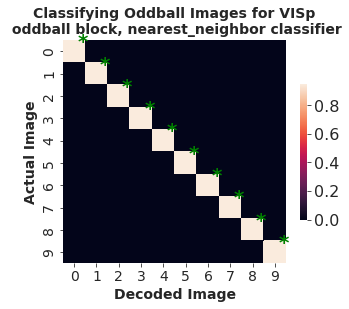

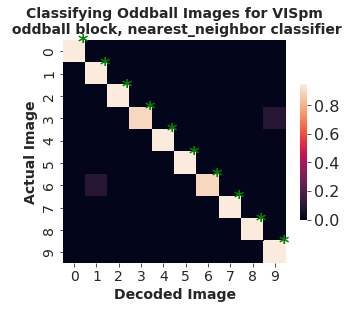

In [18]:
classifier = 'nearest_neighbor'

for area in areanames:
 
    #Get trials where MS images were presented from the middle of the oddball block
    X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pseudopop_responses[area], stimulus_df, block='oddball', trial_type='X')
    
    #Use pseudopopulation vectors for decoding
    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,method='kfold',nKfold=10,classifier=classifier,clabels=oddball_ids)

    fpath = os.path.join(SaveDir,'X-img_decoding_transition-ctrl-block_{}_{}.mat'.format(area,classifier))
    with h5py.File(fpath,'w') as h5file:
        h5file.create_dataset('confusion_mat',data=confusion_mat)
        h5file.create_dataset('confusion_shf',data=confusion_shf)
        h5file.create_dataset('confusion_z',data=confusion_z)
        h5file.create_dataset('area',data=area)
        h5file.create_dataset('classifier',data=classifier)
        h5file.create_dataset('method',data=method)

    title_str = 'Classifying Oddball Images for {}\n oddball block, {} classifier'.format(area,classifier)
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=np.arange(10),title=title_str,annot=False)
    plt.savefig(os.path.join(PlotDir,'X-img_decoding_oddball-blocks_{}_{}.png'.format(area,classifier)))

### Try to decode oddball images vs the previous main sequence in the oddball block
ABCD---X; i.e. the ABC trials are as far away from an oddball presentation as possible

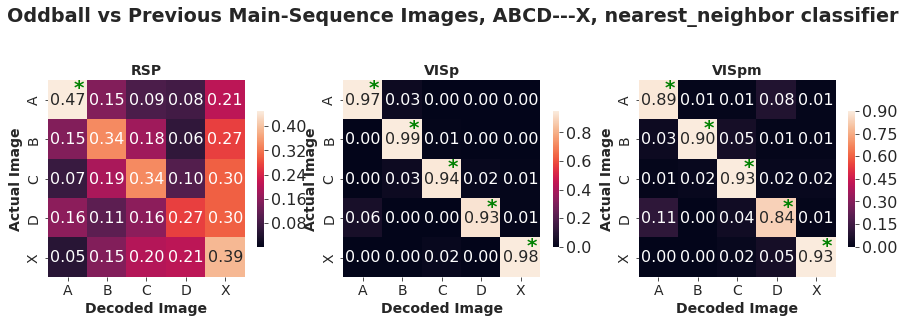

In [23]:
classifier = 'nearest_neighbor'

fig, axes = plt.subplots(1,3,figsize=(15,5))
for ii, area in enumerate(areanames):
 
    #Get trials where MS images were presented from the middle of the oddball block
    X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pseudopop_responses[area], stimulus_df, block='oddball', trial_type='ABCDX')
    
    #Use pseudopopulation vectors for decoding
    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,method='kfold',nKfold=10,classifier=classifier,clabels=[68, 78, 13, 26, 1])

    fpath = os.path.join(SaveDir,'prevMSvsX_decoding_oddball-block_{}_{}.mat'.format(area,classifier))
    with h5py.File(fpath,'w') as h5file:
        h5file.create_dataset('confusion_mat',data=confusion_mat)
        h5file.create_dataset('confusion_shf',data=confusion_shf)
        h5file.create_dataset('confusion_z',data=confusion_z)
        h5file.create_dataset('area',data=area)
        h5file.create_dataset('classifier',data=classifier)
        h5file.create_dataset('method',data=method)

    dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D','X'],title=area,annot=True)
plt.suptitle('Oddball vs Previous Main-Sequence Images, ABCD---X, {} classifier'.format(classifier))
plt.savefig(os.path.join(PlotDir,'prevMSvsX_decoding_oddball-blocks_{}.png'.format(classifier)))

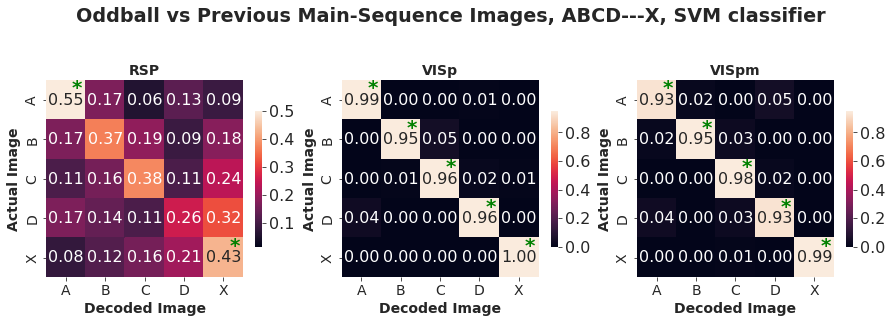

In [33]:
classifier = 'SVM'

fig, axes = plt.subplots(1,3,figsize=(15,5))
for ii, area in enumerate(areanames):
 
    #Get trials where MS images were presented from the middle of the oddball block
    X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pseudopop_responses[area], stimulus_df, block='oddball', trial_type='ABCDX')
    
    #Use pseudopopulation vectors for decoding
    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,method='kfold',nKfold=10,classifier=classifier,clabels=[68, 78, 13, 26, 1])

    fpath = os.path.join(SaveDir,'prevMSvsX_decoding_oddball-block_{}_{}.mat'.format(area,classifier))
    with h5py.File(fpath,'w') as h5file:
        h5file.create_dataset('confusion_mat',data=confusion_mat)
        h5file.create_dataset('confusion_shf',data=confusion_shf)
        h5file.create_dataset('confusion_z',data=confusion_z)
        h5file.create_dataset('area',data=area)
        h5file.create_dataset('classifier',data=classifier)
        h5file.create_dataset('method',data=method)

    dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D','X'],title=area,annot=True)
plt.suptitle('Oddball vs Previous Main-Sequence Images, ABCD---X, {} classifier'.format(classifier))
plt.savefig(os.path.join(PlotDir,'prevMSvsX_decoding_oddball-blocks_{}.png'.format(classifier)))

### Try to decode oddball images vs the main sequence immediately following the oddball
XABCD i.e. the ABCD trials are as close to the oddball presentations as possible

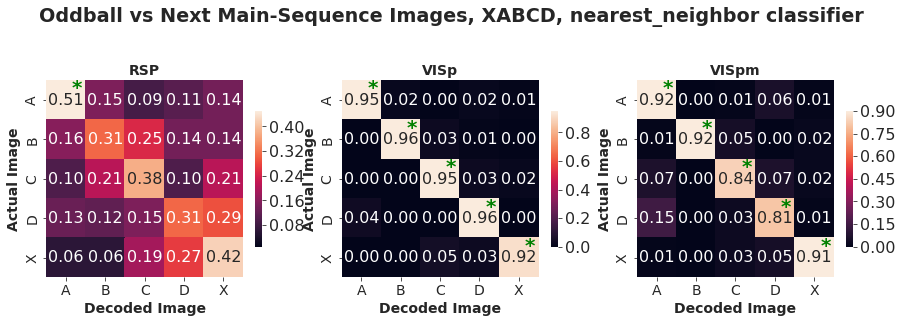

In [24]:
classifier = 'nearest_neighbor'

fig, axes = plt.subplots(1,3,figsize=(15,5))
for ii, area in enumerate(areanames):
 
    #Get trials where MS images were presented from the middle of the oddball block
    X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pseudopop_responses[area], stimulus_df, block='oddball', trial_type='XABCD')
    
    #Use pseudopopulation vectors for decoding
    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,method='kfold',nKfold=10,classifier=classifier,clabels=[68, 78, 13, 26, 1])

    fpath = os.path.join(SaveDir,'nextMSvsX_decoding_oddball-block_{}_{}.mat'.format(area,classifier))
    with h5py.File(fpath,'w') as h5file:
        h5file.create_dataset('confusion_mat',data=confusion_mat)
        h5file.create_dataset('confusion_shf',data=confusion_shf)
        h5file.create_dataset('confusion_z',data=confusion_z)
        h5file.create_dataset('area',data=area)
        h5file.create_dataset('classifier',data=classifier)
        h5file.create_dataset('method',data=method)

    dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D','X'],title=area,annot=True)
plt.suptitle('Oddball vs Next Main-Sequence Images, XABCD, {} classifier'.format(classifier))
plt.savefig(os.path.join(PlotDir,'nextMSvsX_decoding_oddball-blocks_{}.png'.format(classifier)))

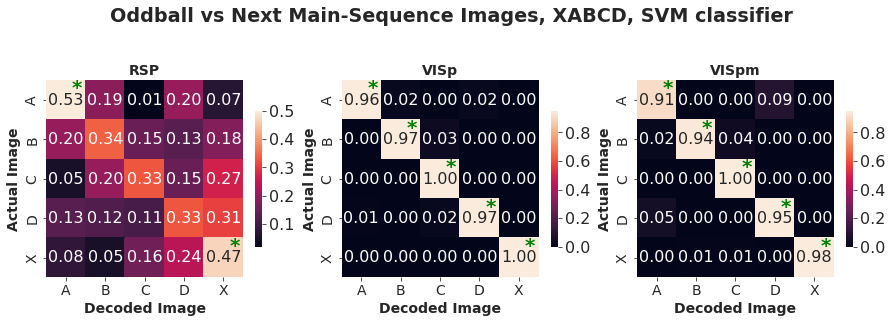

In [34]:
classifier = 'SVM'

fig, axes = plt.subplots(1,3,figsize=(15,5))
for ii, area in enumerate(areanames):
 
    #Get trials where MS images were presented from the middle of the oddball block
    X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pseudopop_responses[area], stimulus_df, block='oddball', trial_type='XABCD')
    
    #Use pseudopopulation vectors for decoding
    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,method='kfold',nKfold=10,classifier=classifier,clabels=[68, 78, 13, 26, 1])

    fpath = os.path.join(SaveDir,'nextMSvsX_decoding_oddball-block_{}_{}.mat'.format(area,classifier))
    with h5py.File(fpath,'w') as h5file:
        h5file.create_dataset('confusion_mat',data=confusion_mat)
        h5file.create_dataset('confusion_shf',data=confusion_shf)
        h5file.create_dataset('confusion_z',data=confusion_z)
        h5file.create_dataset('area',data=area)
        h5file.create_dataset('classifier',data=classifier)
        h5file.create_dataset('method',data=method)

    dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D','X'],title=area,annot=True)
plt.suptitle('Oddball vs Next Main-Sequence Images, XABCD, {} classifier'.format(classifier))
plt.savefig(os.path.join(PlotDir,'nextMSvsX_decoding_oddball-blocks_{}.png'.format(classifier)))